Project: Short-term wind power forecast.

---

In [1]:
#! /usr/bin/env python
#Coding: utf-8
#
#Credits: Panchenko Dmitriy (D.Panchenko@stud.satbayev.university)
#Created: 16-03-2022

#  Working enviroment setup

In [2]:
#Importing libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.figsize'] = 13, 5

import datetime as dt

import torch
from torch import nn

from sklearn.model_selection import train_test_split

In [3]:
#Check for available GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-472be0a3-9cc1-2e35-fd6b-03f504b8d34d)


In [4]:
#Transfer all calculations to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Current device is: {device}')

if device == 'cuda':
    print(torch.cuda.get_device_name(device=device))

Current device is: cuda
Tesla T4


# Dataset Analyze

Data source used for trainig model was provided from [kaggle.com](https://)


---
Dataset details:

*The provided full-year hourly time-series are simulated using the National Renewable Energy Laboratory (NREL) software for a location in Texas, US. It has perfect data completeness, and no noisy data; challenges that hinder forecasting tasks with real datasets and distract from the goal.
The dataset contains various weather features which can be analyzed and used as predictors.*

---
Wind Turbine details:

* Rotor diameter 111m
* Rated output 3600kW
* Hub height 80m
* Single Wind Turbine

Data source: [https://www.kaggle.com/pravdomirdobrev/texas-wind-turbine-dataset-simulated](https://www.kaggle.com/pravdomirdobrev/texas-wind-turbine-dataset-simulated)

In [5]:
#Importing Dataset
data = pd.read_csv("TexasTurbine.csv")
data.head()

,Time stamp,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
0,"Jan 1, 12:00 am",1766.64,9.926,128,1.000480,18.263
1,"Jan 1, 01:00 am",1433.83,9.273,135,0.999790,18.363
2,"Jan 1, 02:00 am",1167.23,8.660,142,0.999592,18.663
3,"Jan 1, 03:00 am",1524.59,9.461,148,0.998309,18.763
4,"Jan 1, 04:00 am",1384.28,9.184,150,0.998507,18.963


In [6]:
#Getting info about Dataset
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Time stamp                     8760 non-null   object 
 1   System power generated | (kW)  8760 non-null   float64
 2   Wind speed | (m/s)             8760 non-null   float64
 3   Wind direction | (deg)         8760 non-null   int64  
 4   Pressure | (atm)               8760 non-null   float64
 5   Air temperature | ('C)         8760 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 410.8+ KB


,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,964.467934,7.376120,146.616210,0.992368,22.147298
std,878.558112,3.138291,84.678754,0.005332,4.855232
min,0.000000,0.119000,0.000000,0.974514,3.263000
25%,215.951500,5.121000,99.000000,0.988925,19.463000
50%,693.968500,7.340500,135.000000,0.991495,22.763000
75%,1562.287500,9.599000,169.000000,0.995045,26.063000
max,3004.010000,19.743000,360.000000,1.014510,32.963000


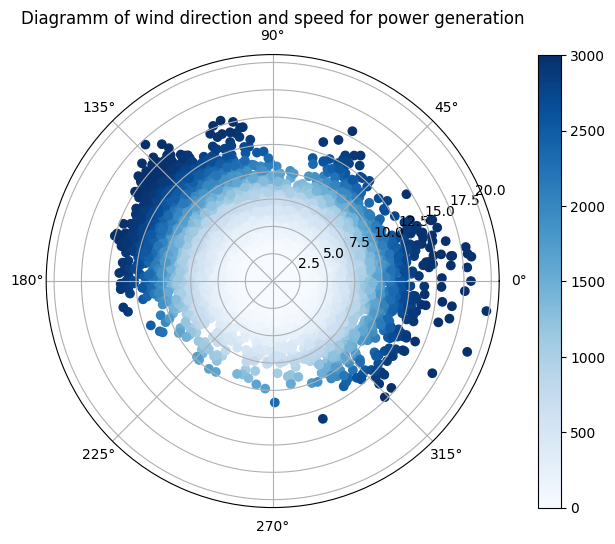

In [7]:
plt.figure(figsize=(10,6), dpi=100)
ax = plt.subplot(projection='polar')
pc = ax.scatter(x=[np.radians(x) for x in data['Wind direction | (deg)']], 
                y=data['Wind speed | (m/s)'],
                c=data['System power generated | (kW)'],
                cmap='Blues',)
plt.colorbar(pc)

plt.title('Diagramm of wind direction and speed for power generation');

,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
System power generated | (kW),1.000000,0.954760,-0.044963,-0.129611,-0.015646
Wind speed | (m/s),0.954760,1.000000,-0.075695,-0.128648,0.005544
Wind direction | (deg),-0.044963,-0.075695,1.000000,-0.017397,-0.172115
Pressure | (atm),-0.129611,-0.128648,-0.017397,1.000000,-0.605576
Air temperature | ('C),-0.015646,0.005544,-0.172115,-0.605576,1.000000


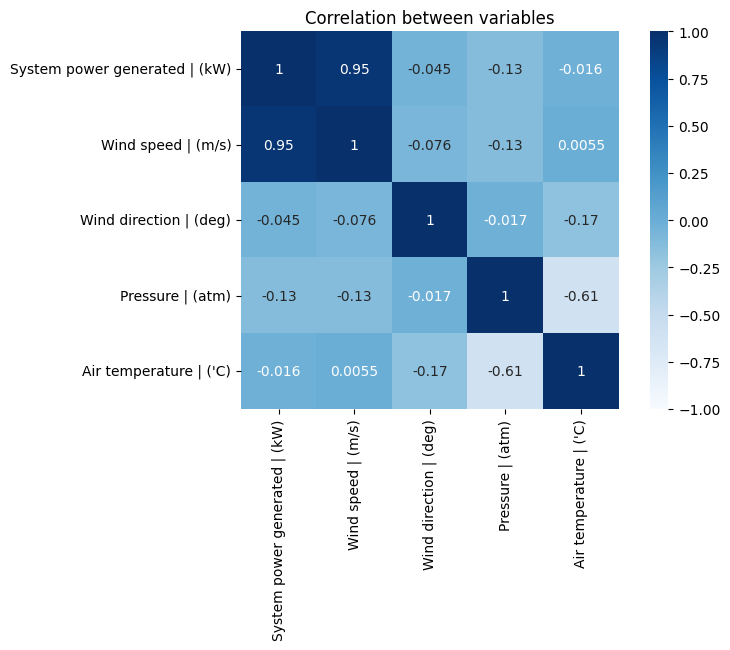

In [8]:
plt.figure(figsize=(8,5), dpi=100)
data_correlation = data.corr()
ax = sns.heatmap(data_correlation, cmap='Blues', annot = True, square=True, vmin = -1, vmax = 1)
plt.title('Correlation between variables')

data_correlation

# Preparing the dataset for training

In [9]:
#Coping dataset to new variable
data_T = data.copy()
data_T.head()

,Time stamp,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
0,"Jan 1, 12:00 am",1766.64,9.926,128,1.000480,18.263
1,"Jan 1, 01:00 am",1433.83,9.273,135,0.999790,18.363
2,"Jan 1, 02:00 am",1167.23,8.660,142,0.999592,18.663
3,"Jan 1, 03:00 am",1524.59,9.461,148,0.998309,18.763
4,"Jan 1, 04:00 am",1384.28,9.184,150,0.998507,18.963


In [10]:
# #Converting time format from am/pm to 24hrs
# data_T['Time stamp'] = pd.to_datetime(data_T['Time stamp'], format='%b %d, %I:%M %p').dt.strftime('%b %d, %H:%M')
# data_T.head(24)

In [11]:
#Deleting time stamp column
data_T.drop(['Time stamp'],axis=1, inplace=True)
data_T.head()

,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
0,1766.64,9.926,128,1.000480,18.263
1,1433.83,9.273,135,0.999790,18.363
2,1167.23,8.660,142,0.999592,18.663
3,1524.59,9.461,148,0.998309,18.763
4,1384.28,9.184,150,0.998507,18.963


In [12]:
#Scaling all values

#Standardizing Genereted Power
power_mean = data_T['System power generated | (kW)'].mean()
power_std = data_T['System power generated | (kW)'].std()
data_T['System power generated | (kW)'] = (data_T['System power generated | (kW)'] - power_mean) / power_std

#Standardizing Wind Speed
windSpeed_mean = data_T['Wind speed | (m/s)'].mean()
windSpeed_std = data_T['Wind speed | (m/s)'].std()
data_T['Wind speed | (m/s)'] = (data_T['Wind speed | (m/s)'] - windSpeed_mean) / windSpeed_std

#Standardizing Wind Direction
windDirection_mean = data_T['Wind direction | (deg)'].mean()
windDirection_std = data_T['Wind direction | (deg)'].std()
data_T['Wind direction | (deg)'] = (data_T['Wind direction | (deg)'] - windDirection_mean) / windDirection_std

#Standardizing Air Temperature
temperature_mean = data_T["Air temperature | ('C)"].mean()
temperature_std = data_T["Air temperature | ('C)"].std()
data_T["Air temperature | ('C)"] = (data_T["Air temperature | ('C)"] - temperature_mean) / temperature_std

data_T.head()

,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
0,0.913055,0.812506,-0.219845,1.000480,-0.800023
1,0.534241,0.604431,-0.137180,0.999790,-0.779427
2,0.230790,0.409102,-0.054514,0.999592,-0.717638
3,0.637547,0.664336,0.016342,0.998309,-0.697041
4,0.477842,0.576071,0.039960,0.998507,-0.655849


In [13]:
#Preparing inputs and outputs for training
inputs = ['Wind speed | (m/s)', 'Wind direction | (deg)', 'Pressure | (atm)', "Air temperature | ('C)"]
x = torch.tensor(data_T[inputs].values, dtype=torch.float, device=device) #using gpu

outputs = ['System power generated | (kW)']
y = torch.tensor(data_T[outputs].values, dtype=torch.float, device=device)

In [14]:
#Check tensor values
print(x[0:5])
print(y[0:5])

x.unsqueeze_(1)
y.unsqueeze_(1)
x.unsqueeze_(1)
y.unsqueeze_(1)

print(x[0:5])
print(y[0:5])

tensor([[ 0.8125, -0.2198,  1.0005, -0.8000],
        [ 0.6044, -0.1372,  0.9998, -0.7794],
        [ 0.4091, -0.0545,  0.9996, -0.7176],
        [ 0.6643,  0.0163,  0.9983, -0.6970],
        [ 0.5761,  0.0400,  0.9985, -0.6558]], device='cuda:0')
tensor([[0.9131],
        [0.5342],
        [0.2308],
        [0.6375],
        [0.4778]], device='cuda:0')
tensor([[[[ 0.8125, -0.2198,  1.0005, -0.8000]]],


        [[[ 0.6044, -0.1372,  0.9998, -0.7794]]],


        [[[ 0.4091, -0.0545,  0.9996, -0.7176]]],


        [[[ 0.6643,  0.0163,  0.9983, -0.6970]]],


        [[[ 0.5761,  0.0400,  0.9985, -0.6558]]]], device='cuda:0')
tensor([[[[0.9131]]],


        [[[0.5342]]],


        [[[0.2308]]],


        [[[0.6375]]],


        [[[0.4778]]]], device='cuda:0')


# Splitting the dataset

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=666)

x_test = x_test.to(device)
y_test = y_test.to(device)

# Model building

In [16]:
#Definig class for our model
class WindNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WindNet, self).__init__()
        self.fc1 = torch.nn.Linear(4, n_hidden_neurons)
        self.act1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

wind_net = WindNet(100)

In [17]:
#Init model starting parametrs
wind_net = wind_net.to(device)
list(wind_net.parameters())

[Parameter containing:
 tensor([[ 0.4931, -0.2235, -0.1132,  0.3641],
         [ 0.3237,  0.3500, -0.3753, -0.2621],
         [-0.0447,  0.3332,  0.1435,  0.3018],
         [-0.1794,  0.0228,  0.2402, -0.0469],
         [ 0.0511, -0.4311, -0.2488,  0.3537],
         [-0.0845, -0.2180,  0.0995, -0.1334],
         [ 0.3047,  0.2175,  0.0034,  0.1482],
         [ 0.4752, -0.0959, -0.0420,  0.3568],
         [-0.2776, -0.0335,  0.4550,  0.2903],
         [ 0.3533, -0.1700, -0.0182, -0.4376],
         [-0.2418,  0.2280, -0.1794,  0.3050],
         [-0.4296, -0.1452, -0.2939,  0.3781],
         [ 0.4369, -0.4881, -0.2139, -0.1593],
         [-0.1143, -0.0924,  0.4283, -0.1493],
         [-0.4487, -0.0083, -0.0528, -0.0669],
         [ 0.0303,  0.4709,  0.3553,  0.4895],
         [ 0.3114,  0.4783,  0.4073, -0.2465],
         [ 0.3789,  0.2583, -0.3449, -0.4827],
         [ 0.1230,  0.0619,  0.4959,  0.1641],
         [-0.4641,  0.1981, -0.3843, -0.4594],
         [-0.4634, -0.2637,  0.3722, 

In [18]:
#Defining the optimizer for our model
optimizer = torch.optim.Adam(wind_net.parameters(), lr=0.01)

In [19]:
#Defining the loss function
def loss(pred, target):
    return (pred - target).abs().mean()

In [20]:
#Getting metrics for the model
def metric(pred, target):
    return (pred - target).abs().mean()
print(metric(wind_net.forward(x), y).item())

0.8432835340499878


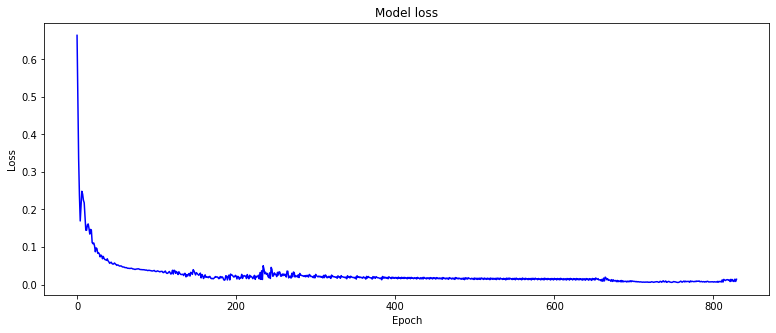

In [21]:
#Start model trainig
loss_plot = []
for epoch_index in range(830):
    optimizer.zero_grad()
    y_pred = wind_net.forward(x_train)
    loss_val = loss(y_pred, y_train)
    loss_val.backward()
    optimizer.step()
    loss_plot.append(metric(wind_net.forward(x_test), y_test).item())
plt.plot(loss_plot, 'b')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [22]:
#Getting predictions from model
@torch.no_grad()
def predict(net, x, y, minValue, maxValue):
    net.eval()
    predictions = []
    actual = []
    x.to(device)
    y.to(device)
    net.to(device)

    for i in range(len(x)):
        pred = net(x[i])

        pred = (pred * power_std) + power_mean
        act = (y[i] * power_std) + power_mean
        # print(f"Predicted: {pred}, Actual: {act}")
        predictions.append(pred.tolist())
        actual.append(act.item())
    plt.title('Prediction vs Actual')
    plt.scatter(actual, predictions,color='b', zorder=2)
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    plt.plot([minValue, maxValue], [minValue, maxValue], color='r', lw=1.5, zorder=2)
    plt.xlim(minValue, maxValue)
    plt.ylim(minValue, maxValue)
    plt.gca().set_aspect('equal', adjustable='box')

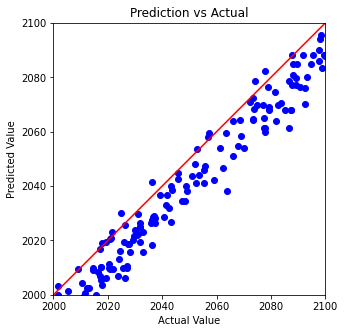

In [24]:
predict(wind_net, x, y, 2000, 2100)